In [1]:
# Load packages
suppressMessages(library(saqgetr))
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openxlsx))
suppressMessages(library(plyr))

suppressMessages(library(openair))
suppressMessages(library(gridExtra))

suppressMessages(library(doParallel))
suppressMessages(library(caret))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

load("data/data_AQ.rda")
load("data/meteorology.rda")

# Lockdown dates

In [4]:
periods <- list(
    # lockdown
    lockdown = ymd("2020-03-14"),
    #end.lockdown = as.numeric(ymd_hms("2020-04-28 00:00:00")),

    # poslockdown
    fases = ymd("2020-05-01"),
    normalidad = ymd("2020-06-21"),

    # New lockdown
    new.lockdown = ymd("2020-10-25")
)

## Load Data

In [5]:
aq <- data_AQ[data_AQ$site == "es0118a", ] %>%
            filter(variable == "no2") %>%
            timeAverage(avg.time = "day")
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == "es0118a", ]

df <- merge(aq, mto,
              by = "date", all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -site)

rm(data_AQ)
rm(data_Mto)
head(df)

,date,value,ws,wd,atmos_pres,tmed,prec,tmin,tmax,presMax,presMin,RH,solar.radiation
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013-01-01,41.95833,0.8571429,225.29494,1022.433,6.4,0,3.4,9.4,945.9,940.2,80.65828,58.83178
2,2013-01-02,59.91667,0.9321429,355.50018,1027.800,5.8,0,0.7,10.8,950.3,945.9,75.60469,71.71485
3,2013-01-03,67.41667,0.8607143,75.49246,1036.733,6.8,0,2.8,10.8,959.8,950.3,67.31548,84.82211
4,2013-01-05,86.33333,0.4500000,261.60039,1035.133,4.9,0,-0.4,10.2,956.8,952.9,73.00545,110.16858
5,2013-01-06,70.04167,0.4892857,178.49970,1031.567,5.1,0,0.7,9.5,953.0,949.6,80.61580,111.74950
6,2013-01-07,48.70833,0.4107143,278.81272,1031.000,3.2,0,1.5,4.8,951.3,949.6,86.99924,112.96824


In [6]:
train <-  which(df$date < ymd("2020-01-01"))

In [7]:
df.data <- df %>%
        select(-date) %>% scale() %>%
        data.frame()
time <- df$date

## Analysis

In [8]:
anly.data <- df.data

In [9]:
# Set seed for reproducibility
set.seed(100)


cores <- 4
cl <- makePSOCKcluster(cores)
registerDoParallel(cl)

samp <- createDataPartition(anly.data$value[train], p = 0.75, list = FALSE)

# Set up the resampling, here repeated CV
tr <- trainControl(method = "repeatedcv", number = 10, repeats = 5, )
rf.caret <- c()
RMSE <- c()


for (ntree in c(50)) {
    
    ## fitting with caret
    rf.caret = c(rf.caret,
                 train(value ~., anly.data, subset = samp,
                       preProcess = c("range"),
                       method = "rf", ntree=ntree,

                       tuneGrid = expand.grid(mtry = 1:11), 
                       trControl=tr
                      ))
}

## When you are done:
stopCluster(cl)

In [10]:
test <- which(df$date > ymd("2020-01-01"))
y.th <- predict(rf.caret$finalModel, newdata = anly.data[test,])

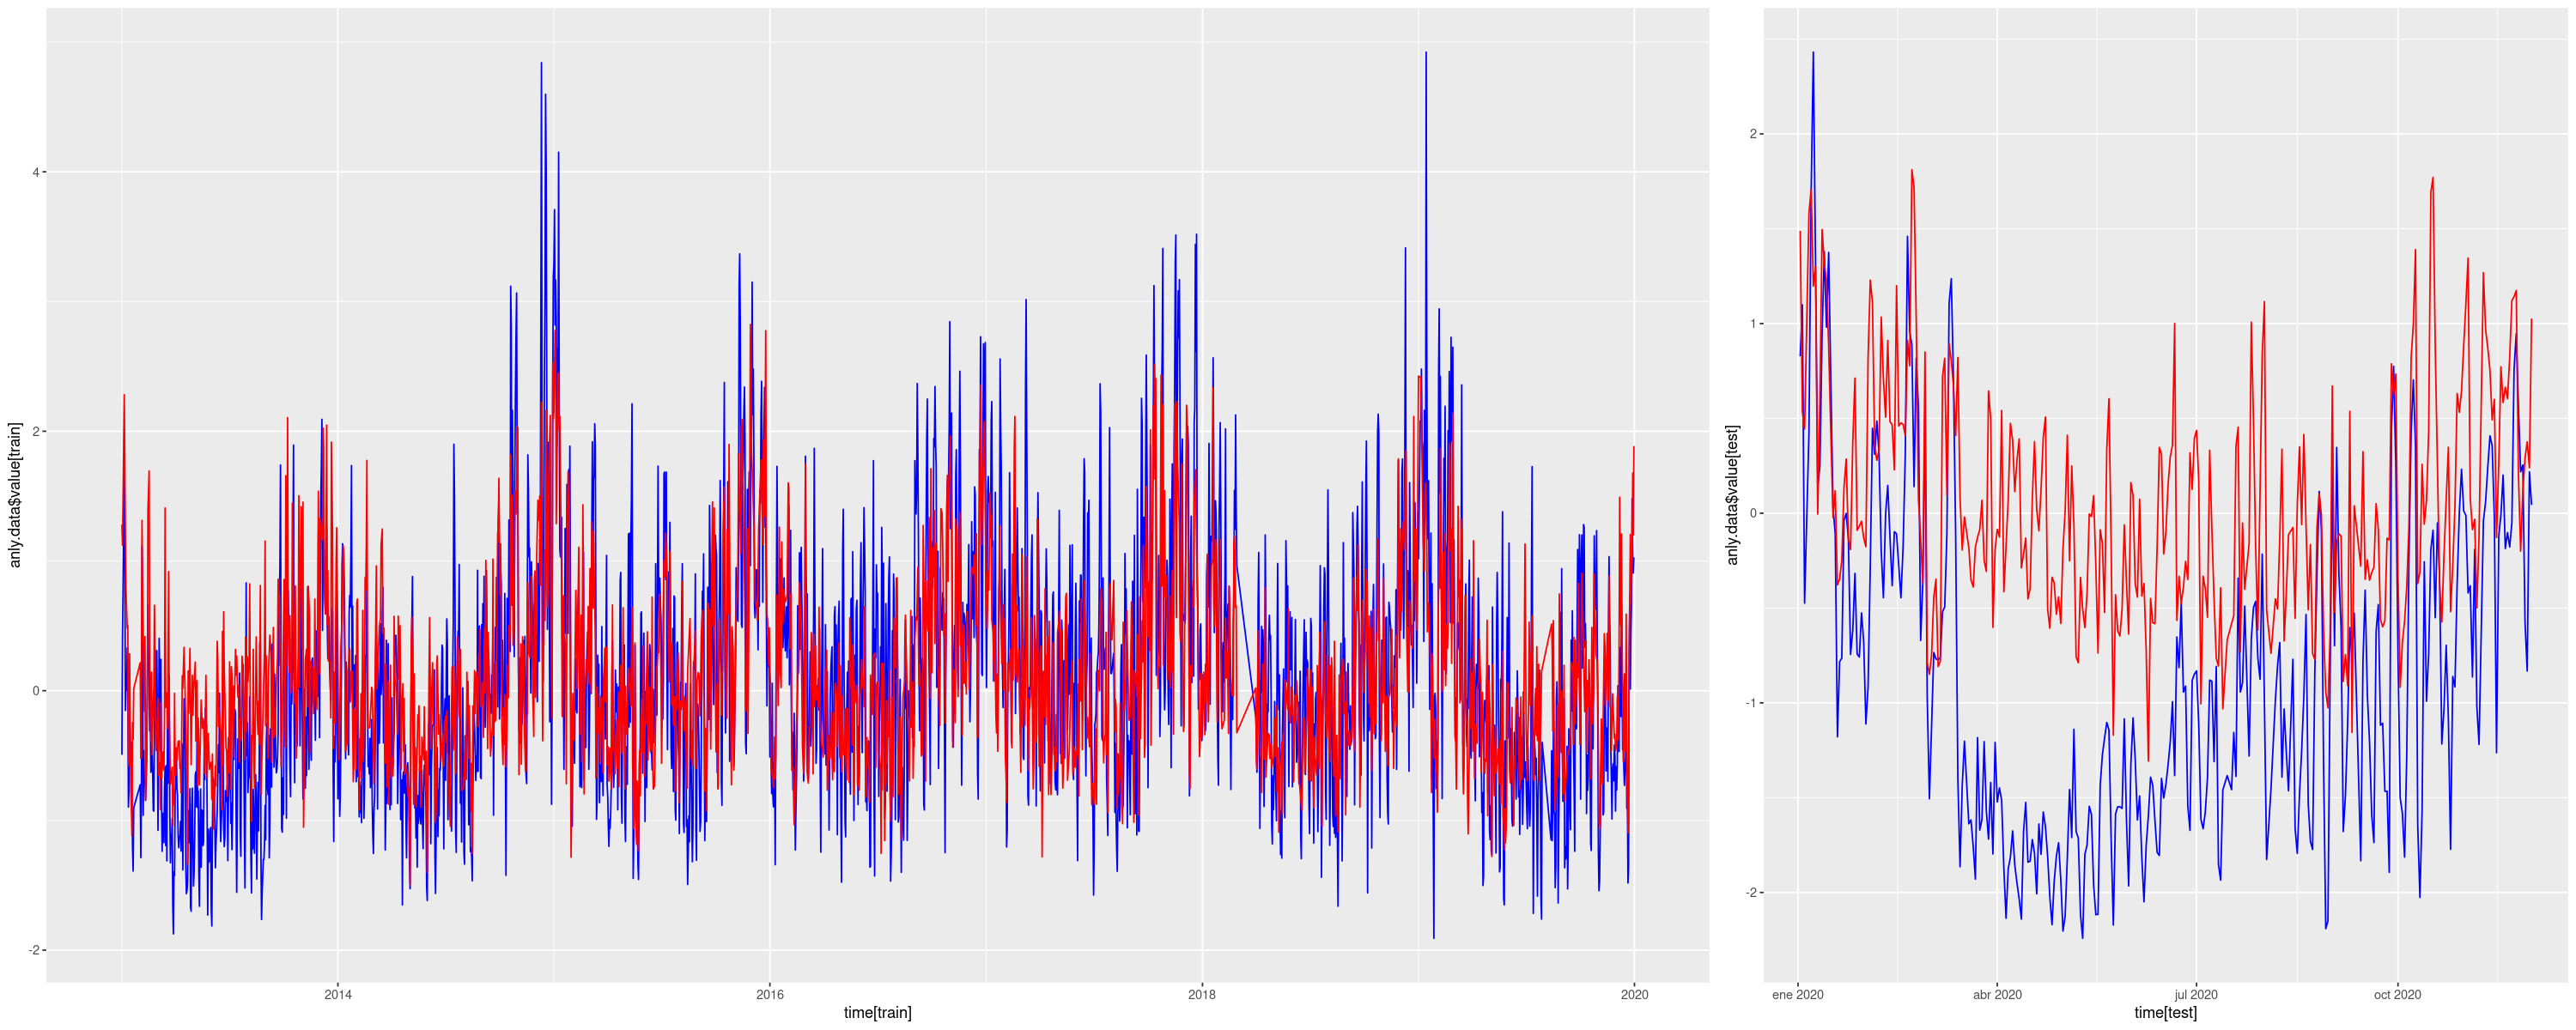

In [11]:
all.series <- ggplot() +
                geom_line(aes(x = time[train], y = anly.data$value[train]), color="blue") +
                geom_line(aes(x = time[samp], y = rf.caret$finalModel$predicted), color="red")
last.series <- ggplot() +
                geom_line(aes(x = time[test], y = anly.data$value[test]), color="blue") +
                geom_line(aes(x = time[test], y = y.th), color="red")

grid.arrange(all.series, last.series, nrow = 1, widths = c(2, 1))